# Importing Modules and Checking Directory 

In [1]:
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
pd.__version__

'1.1.5'

In [3]:
os.getcwd()


'/Users/Livi/Projects/Black_mental_health/models'

### Loading data, making dummy columns

In [4]:
df = pd.read_csv('../data/interim/features_and_target2_pre_get_dummies.csv', index_col=0)
y = df.payrate_level
X = pd.get_dummies(df.drop(columns='payrate_level'))

/Users/Livi/opt/anaconda3/envs/springboard/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### Using best way of scaling from preprocessing: only continous features not binary columns

In [5]:
from sklearn.preprocessing import PowerTransformer
import time

start= time.time()

scaler = PowerTransformer()

X_scaled=X.copy()

for col in X.columns:
    if col =='entity_code_I':
        break
    else:
        scaler.fit(np.array(X[col]).reshape(-1,1))
        i_scaled = scaler.transform(np.array(X[col]).reshape(-1,1))
        X[col] = i_scaled
        
        
end= time.time()

print('Time scaled:', (end-start)/60, 'minutes.')

Time scaled: 0.6124389330546062 minutes.


In [6]:
X.head()

number_of_hcpcs  number_of_services  total_beneficiaries  \
0        -0.003948            0.540055             0.851671   
1        -0.170174            0.576787             1.015528   
2        -1.402499           -1.478753            -2.032970   
3         0.447350            1.158778             1.311877   
4         0.139490           -0.443103            -0.613947   

   total_submitted_charges  avg_beneficiary_age  avg_hcc_risk_score  \
0                 1.196155             0.998501            1.105662   
1                 0.573919             2.139463            0.994263   
2                -2.079729            -1.181247           -1.398919   
3                 1.152199             1.833739           -0.416924   
4                -0.657554            -0.706375            1.649911   

   submitted_charges_per_person  services_per_person  \
0                      0.871076            -0.119979   
1                     -0.276118            -0.317600   
2                     -1.041626             0.565058   
3                      0.242840             0.442297   
4                     -0.268393             0.241994   

   submitted_charges_per_service  total_pop  ...  subregion_Pacific  \
0                       1.063762   0.781846  ...                  0   
1                       0.179416  -0.074416  ...                  0   
2                      -1.326987  -0.413310  ...                  0   
3                       0.106138   0.795532  ...                  0   
4                      -0.223406  -0.679061  ...                  0   

   subregion_South Atlantic  subregion_West North Central  \
0                         1                             0   
1                         1                             0   
2                         1                             0   
3                         1                             0   
4                         1                             0   

   subregion_West South Central  majority_majority_asian  \
0                             0                        0   
1                             0                        0   
2                             0                        0   
3                             0                        0   
4                             0                        0   

   majority_majority_black  majority_majority_hispanic  \
0                        0                           0   
1                        0                           0   
2                        1                           0   
3                        0                           0   
4                        0                           0   

   majority_majority_native_amer  majority_majority_white  \
0                              0                        1   
1                              0                        1   
2                              0                        0   
3                              0                        0   
4                              0                        0   

   majority_no_majority  
0                     0  
1                     0  
2                     0  
3                     1  
4                     1  

[5 rows x 188 columns]

### Splitting data

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size = 0.2, random_state=2)

In [8]:
X_train.shape, y_train.shape

((857713, 188), (857713,))

### Training on All Data

#### Random Forest

In [15]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

rf = RandomForestClassifier(n_jobs=-1)

start = time.time()

rf.fit(X_train, y_train)
ypred_rf = rf.predict(X_test)

end= time.time()
total = end - start

f1_rf = f1_score(y_test, ypred_rf, average='weighted')
print('RF F1 Score:', f1_rf)
print("Time:", total/60, "minutes")

RF F1 Score: 0.6569304490198083
Time: 0.3454479813575745 minutes


#### Logistic Regression

In [35]:
import time
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(n_jobs=-1)

start = time.time()

lr.fit(X_train, y_train)
ypred_lr = lr.predict(X_test)

end= time.time()
total = end - start

f1_lr = f1_score(y_test, ypred_lr, average='weighted')
print('RF F1 Score:', f1_lr)
print("Time:", total/60, "minutes")

RF F1 Score: 0.622272977808401
Time: 0.33096450169881186 minutes


In [36]:
scores = pd.DataFrame({'models':['Random Forest', 'Logistic Regression'],
             'F1 Scores': [f1_rf, f1_lr],
                      })
scores

models  F1 Scores
0        Random Forest   0.656930
1  Logistic Regression   0.622273

# Tuning

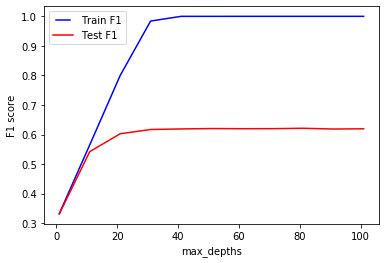

time: 9.47630048195521 minutes


In [58]:
from sklearn.metrics import f1_score
import time

start = time.time()

max_depths = np.arange(1, 111, 10)
x_train = X_train
y_train = y_train
x_test = X_test
y_test = y_test
train_results = []
test_results = []
for max_depth in max_depths:
    model = RandomForestClassifier(max_depth=max_depth)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    f1 = f1_score(y_train, train_pred, average = 'weighted')
    train_results.append(f1)
    y_pred = model.predict(x_test)
    f1 = f1_score(y_test, y_pred,average = 'weighted')
    test_results.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train F1')
line2, = plt.plot(max_depths, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('max_depths')
plt.show()

end =time.time()
print("time:", (end-start)/60, 'minutes')

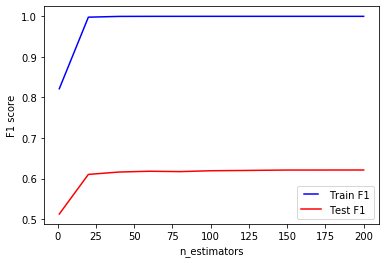

time: 8.373383716742199 minutes


In [59]:
start = time.time()

x_train = X_train
y_train = y_train
x_test = X_test
y_test = y_test

n_estimators = [1, 20, 40, 60, 80, 100, 120, 150, 200]
train_results = []
test_results = []
for n_estimator in n_estimators:
    model = RandomForestClassifier(n_estimators=n_estimator)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    f1 = f1_score(y_train, train_pred,average = 'weighted')
    train_results.append(f1)
    y_pred = model.predict(x_test)
    f1 = f1_score(y_test, y_pred,average = 'weighted')
    test_results.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train F1')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('n_estimators')
plt.show()

end =time.time()
print("time:", (end-start)/60, 'minutes')

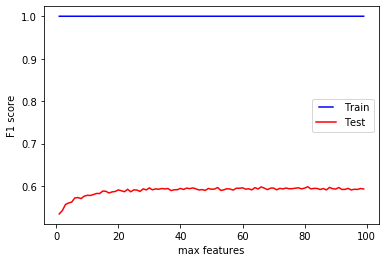

In [54]:
start = time.time()

x_train = X_train
y_train = y_train
x_test = X_test
y_test = y_test


max_features = list(range(1,100))
train_results = []
test_results = []
for max_feature in max_features:
    model = RandomForestClassifier(max_features=max_feature)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    f1 = f1_score(y_train, train_pred,average = 'weighted')
    train_results.append(f1)
    y_pred = model.predict(x_test)
    f1 = f1_score(y_test, y_pred,average = 'weighted')
    test_results.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train')
line2, = plt.plot(max_features, test_results, 'r', label='Test')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('max features')
plt.show()

end = time.time()
print('time:', (end-start)/60, 'minutes')

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from timeit import default_timer as timer

X_train, X_test, y_train, y_test = train_test_split(X[:100000], y.values.ravel()[:100000], test_size = 0.2, random_state=2)


start = timer()
model = RandomForestClassifier()
max_depth = [10, 20, 30, 40, 50]
#criterion=['gini','entropy']
n_estimators = [20, 40, 60, 80, 100]
max_features= [5, 10, 15, 20, 25]
#class_weight=['balanced']

grid = dict(max_depth=max_depth, n_estimators=n_estimators, max_features=max_features)
scorer = make_scorer(f1_score, average = 'weighted')
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring=scorer)
grid_result = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

end = timer()
print("time:", (end - start)/60, 'minutes')

Best: 0.654309 using {'max_depth': 40, 'max_features': 25, 'n_estimators': 100}
time: 67.17298282838334 minutes


In [18]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

scores=[]
parameters=[]

for mean, stdev, param in zip(means, stds, params):
    scores.append(mean)
    parameters.append(param)
    
scores= np.array(scores)
params=np.array(params)
scores.argsort()[-10:]

ps = params[scores.argsort()[-10:]]
ss = scores[scores.argsort()[-10:]]

for p, s in zip(ps, ss):
    print(s, ':', p)

0.65207857898609 : {'max_depth': 50, 'max_features': 15, 'n_estimators': 80}
0.6520848755143331 : {'max_depth': 40, 'max_features': 20, 'n_estimators': 100}
0.6522703562941385 : {'max_depth': 50, 'max_features': 20, 'n_estimators': 60}
0.6523626804213183 : {'max_depth': 30, 'max_features': 25, 'n_estimators': 100}
0.6524151724972379 : {'max_depth': 50, 'max_features': 25, 'n_estimators': 80}
0.6532250599267112 : {'max_depth': 50, 'max_features': 20, 'n_estimators': 80}
0.6534896889819745 : {'max_depth': 50, 'max_features': 20, 'n_estimators': 100}
0.6535197700351276 : {'max_depth': 50, 'max_features': 15, 'n_estimators': 100}
0.6537553854635244 : {'max_depth': 50, 'max_features': 25, 'n_estimators': 100}
0.6543088241792201 : {'max_depth': 40, 'max_features': 25, 'n_estimators': 100}


##### Using suggested metrics #1

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X[:100000], y.values.ravel()[:100000], test_size = 0.2, random_state=2)

In [30]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

rf_tune1 = RandomForestClassifier(n_jobs=-1, max_depth=40, max_features=25, n_estimators=100)

start = time.time()

rf_tune1.fit(X_train, y_train)
ypred_rf_tune1 = rf_tune1.predict(X_test)
f1_rf_tune1 = f1_score(y_test, ypred_rf_tune1, average='weighted')


end= time.time()
total = end - start

print('RF F1 Score:', f1_rf_tune1)
print("Time:", total/60, "minutes")

RF F1 Score: 0.6585952019064046
Time: 0.5856198827425639 minutes


##### Using suggested metrics #2

In [31]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

rf_tune2 = RandomForestClassifier(n_jobs=-1, max_depth=50, max_features=25, n_estimators=100)

start = time.time()

rf_tune2.fit(X_train, y_train)
ypred_rf_tune2 = rf_tune2.predict(X_test)
f1_rf_tune2 = f1_score(y_test, ypred_rf_tune2, average='weighted')

end= time.time()
total = end - start

print('RF F1 Score:', f1_rf_tune2)
print("Time:", total/60, "minutes")

RF F1 Score: 0.6564721232495719
Time: 0.4936505715052287 minutes


##### Using suggested parameters #3

In [32]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

start = time.time()

rf_tune3 = RandomForestClassifier(n_jobs=-1, max_depth=50, max_features=15, n_estimators=100)
rf_tune3.fit(X_train, y_train)
ypred_rf_tune3 = rf_tune3.predict(X_test)
f1_rf_tune3 = f1_score(y_test, ypred_rf_tune3, average='weighted')

end= time.time()
total = end - start

print('RF F1 Score:', f1_rf_tune3)
print("Time:", total/60, "minutes")

RF F1 Score: 0.6553763465961988
Time: 0.42471795082092284 minutes


##### Using suggested parameters #4

In [33]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

start = time.time()

rf_tune4 = RandomForestClassifier(n_jobs=-1, max_depth=50, max_features=20, n_estimators=100)
rf_tune4.fit(X_train, y_train)
ypred_rf_tune4 = rf_tune4.predict(X_test)
f1_rf_tune4 = f1_score(y_test, ypred_rf_tune4, average='weighted')

end= time.time()
total = end - start

print('RF F1 Score:', f1_rf_tune4)
print("Time:", total/60, "minutes")

RF F1 Score: 0.6577537997932067
Time: 0.4137455463409424 minutes


##### Using Randomized Search CV

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size = 0.2, random_state=2)

In [93]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

start = time.time()

params = {'max_depth':randint(1,50),
         'max_features':randint(1,40),
          'n_estimators':randint(10,100),
         'criterion':['gini']}

rf = RandomForestClassifier()

scorer = make_scorer(f1_score, average = 'weighted')

randomized_rf = RandomizedSearchCV(rf, params, cv=5, scoring=scorer)

randomized_rf.fit(X_train, y_train)


end=time.time()
print('time:', (end-start)/60, 'minutes')
print('best params:', randomized_rf.best_params_)
print('best score:', randomized_rf.best_score_)

time: 237.54684102932612 minutes
best params: {'criterion': 'gini', 'max_depth': 35, 'max_features': 17, 'n_estimators': 73}
best score: 0.6448718097819596


#### Using Suggested Parameters #5

In [95]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(X[:100000], y.values.ravel()[:100000], test_size = 0.2, random_state=2)

start = time.time()

rf_tune5 = RandomForestClassifier(n_jobs=-1, max_depth=35, max_features=17, n_estimators=73)
rf_tune5.fit(X_train, y_train)
ypred_rf_tune5 = rf_tune5.predict(X_test)
f1_rf_tune5 = f1_score(y_test, ypred_rf_tune5, average='weighted')

end= time.time()
total = end - start

print('RF F1 Score:', f1_rf_tune5)
print("Time:", total/60, "minutes")

RF F1 Score: 0.6551223008101259
Time: 0.2654785672823588 minutes


Model Metrics Table

In [96]:
scores = pd.DataFrame({'models':['Random Forest', 'Logistic Regression'],
             'F1 Scores, out-of-box': [f1_rf.mean(), f1_lr.mean()],
                      'F1 Scores, Tune1':[f1_rf_tune1.mean(), '--'],
                      'F1 Scores, Tune2': [f1_rf_tune2.mean(), '--'],
                      'F1 Scores, Tune3': [f1_rf_tune3.mean(), '--'],
                      'F1 Scores, Tune4': [f1_rf_tune4.mean(), '--'],
                      'F1 Scores, Tune5': [f1_rf_tune5.mean(), '--']})
scores

models  F1 Scores, out-of-box F1 Scores, Tune1  \
0        Random Forest               0.656930         0.658595   
1  Logistic Regression               0.622273               --   

  F1 Scores, Tune2 F1 Scores, Tune3 F1 Scores, Tune4 F1 Scores, Tune5  
0         0.656472         0.655376         0.657754         0.655122  
1               --               --               --               --

In [41]:
scores.to_csv('../reports/figures/model_scores.csv')

#### Training Best Model on all the Data:

In [9]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size = 0.2, random_state=2)

rf_best = RandomForestClassifier(n_jobs=-1, max_depth=40, max_features=25, n_estimators=100)

start = time.time()

rf_best.fit(X_train, y_train)
ypred_rf_best = rf_best.predict(X_test)
f1_rf_best = f1_score(y_test, ypred_rf_best, average='weighted')


end= time.time()
total = end - start

print('RF F1 Score:', f1_rf_best)
print("Time:", total/60, "minutes")

RF F1 Score: 0.6497838132468272
Time: 32.82812073628108 minutes


#### Showing confusion matrix of best performing model:

Time: 0.20809108416239422 minutes


<Figure size 1440x1440 with 0 Axes>

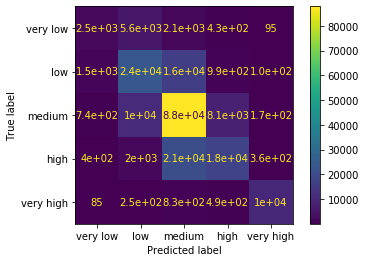

In [62]:
from sklearn.metrics import plot_confusion_matrix

start = time.time()

plt.figure(figsize=(20,20))
z = plot_confusion_matrix(rf_best, X_test, y_test, labels=['very low','low','medium','high','very high'])
plt.savefig('confusion_matrix_RF_best.png')

end=time.time()

print('Time:', (end-start)/60, 'minutes')
z

#### Most important features of best performing model:

In [63]:
pd.DataFrame({
    'Features': X.columns,
    'Importances':rf_best.feature_importances_
            }).sort_values('Importances', ascending=False).head(20)

Features  Importances
6                  submitted_charges_per_person     0.090531
5                            avg_hcc_risk_score     0.073834
8                 submitted_charges_per_service     0.061953
3                       total_submitted_charges     0.061168
7                           services_per_person     0.055767
1                            number_of_services     0.049064
2                           total_beneficiaries     0.044112
0                               number_of_hcpcs     0.043498
15                                percent_asian     0.033756
16                    percent_two_or_more_races     0.033311
9                                     total_pop     0.033273
4                           avg_beneficiary_age     0.033096
13                             percent_hispanic     0.033004
10                                percent_black     0.032702
11                                percent_white     0.032151
12                          percent_native_amer     0.030337
14                                percent_other     0.027938
17                                entity_code_I     0.019515
18                                entity_code_O     0.016897
118  provider_type_Mass Immunizer Roster Biller     0.011026

#### Saving Feature Importances RF

In [11]:
rf_imp = pd.DataFrame({
    'Features': X.columns,
    'Importances':rf_best.feature_importances_
            }).sort_values('Importances', ascending=False)

rf_imp.to_csv('../references/rf_best_feature_imp.csv')

#### Most Extreme Errors from Best Model

In [82]:
idx = X_test.index
examine_errors = pd.read_csv('../data/interim/merged_medicare_before_dropping.csv',index_col=0).loc[idx]
examine_errors = pd.concat([examine_errors.reset_index(drop=True),
                                    pd.Series(ypred_rf_best).rename('ypred'),
                                    pd.Series(y_test).rename('ytest')], axis=1)

/Users/Livi/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
examine_errors.columns

#### I really wanted to see if the payment model is not supporting racial minorities. Let's look at "very high" predictions that were actually "very low"

In [85]:
false_very_high = examine_errors[
    (examine_errors.ypred == 'very high') & (examine_errors.ytest == 'very low')]

false_very_high = false_very_high[['entity_code','state','provider_type','number_of_services','number_of_hcpcs','total_beneficiaries','total_allowed_payment','avg_hcc_risk_score','allowed_payment_per_person','services_per_person','allowed_payment_per_service','region','subregion','total_pop','majority','ytest','ypred']]

In [86]:
false_very_high

entity_code state            provider_type  number_of_services  \
918              I    NM     Diagnostic Radiology                29.0   
2562             I    SD  Certified Nurse Midwife                16.0   
2789             I    KY       Nurse Practitioner               310.0   
5942             I    AR       Nurse Practitioner                39.0   
6948             I    MI          Family Practice                80.0   
...            ...   ...                      ...                 ...   
210794           I    FL          Family Practice                32.0   
211041           I    CA        Internal Medicine                16.0   
211196           I    KY       Nurse Practitioner               959.0   
212055           I    CA          Family Practice                18.0   
213042           I    IN       Nurse Practitioner                34.0   

        number_of_hcpcs  total_beneficiaries  total_submitted_charges  \
918                  17                   15                   726.00   
2562                  4                   15                   903.00   
2789                 32                  119                  7781.04   
5942                 12                   15                  1165.80   
6948                  6                   20                  1936.00   
...                 ...                  ...                      ...   
210794                2                   27                  1175.00   
211041                3                   11                   193.00   
211196               30                  216                 18672.00   
212055                4                   14                   524.00   
213042               12                   19                  1347.00   

        avg_hcc_risk_score  submitted_charges_per_person  services_per_person  \
918                 1.6680                         48.40                 1.93   
2562                0.8483                         60.20                 1.07   
2789                1.5591                         65.39                 2.61   
5942                1.3619                         77.72                 2.60   
6948                1.4554                         96.80                 4.00   
...                    ...                           ...                  ...   
210794              1.2948                         43.52                 1.19   
211041              1.8882                         17.55                 1.45   
211196              1.1510                         86.44                 4.44   
212055              1.0729                         37.43                 1.29   
213042              1.3521                         70.89                 1.79   

        submitted_charges_per_service   region           subregion  total_pop  \
918                             25.03     West            Mountain    24123.0   
2562                            56.44  Midwest  West North Central    22501.0   
2789                            25.10    South  East South Central     6507.0   
5942                            29.89    South  West South Central    56445.0   
6948                            24.20  Midwest  East North Central     8479.0   
...                               ...      ...                 ...        ...   
210794                          36.72    South      South Atlantic    19986.0   
211041                          12.06     West             Pacific    46261.0   
211196                          19.47    South  East South Central     4879.0   
212055                          29.11     West             Pacific    44686.0   
213042                          39.62  Midwest  East North Central    31810.0   

              majority     ytest      ypred  
918        no_majority  very low  very high  
2562    majority_white  very low  very high  
2789    majority_white  very low  very high  
5942       no_majority  very low  very high  
6948    majority_white  very low  very high  
...                ...       ..

In [88]:
false_high = examine_errors[
    (examine_errors.ypred == 'very high') & (examine_errors.ytest == 'low')]

false_high = false_high[['entity_code','state','provider_type','number_of_services','number_of_hcpcs','total_beneficiaries','total_submitted_charges','avg_hcc_risk_score','submitted_charges_per_person','services_per_person','submitted_charges_per_service','region','subregion','total_pop','majority','ytest','ypred']]
false_high.head()

entity_code state       provider_type  number_of_services  \
2394            I    MS  Nurse Practitioner               108.0   
6000            I    NY  Nurse Practitioner                25.0   
9321            I    OK     Family Practice              1096.0   
14825           I    VA     Family Practice                64.0   
15209           I    WA  Nurse Practitioner                44.0   

       number_of_hcpcs  total_beneficiaries  total_submitted_charges  \
2394                28                   44                  4970.10   
6000                 2                   13                   470.00   
9321                25                  443                 28018.00   
14825               13                   45                  1594.68   
15209                8                   29                  1611.67   

       avg_hcc_risk_score  submitted_charges_per_person  services_per_person  \
2394               1.1361                        112.96                 2.45   
6000               0.9095                         36.15                 1.92   
9321               1.0019                         63.25                 2.47   
14825              1.1833                         35.44                 1.42   
15209              1.3272                         55.57                 1.52   

       submitted_charges_per_service     region           subregion  \
2394                           46.02      South  East South Central   
6000                           18.80  Northeast     Middle Atlantic   
9321                           25.56      South  West South Central   
14825                          24.92      South      South Atlantic   
15209                          36.63       West             Pacific   

       total_pop        majority ytest      ypred  
2394     27109.0     no_majority   low  very high  
6000     49068.0     no_majority   low  very high  
9321      6213.0  majority_white   low  very high  
14825    30478.0  majority_white   low  very high  
15209    12445.0  majority_white   low  very high

In [89]:
false_high.majority.value_counts()

majority_white          65
no_majority             24
majority_hispanic       10
majority_black           5
majority_native_amer     1
Name: majority, dtype: int64

In [90]:
false_very_high.majority.value_counts()

majority_white          66
no_majority             16
majority_black           7
majority_hispanic        4
majority_native_amer     2
Name: majority, dtype: int64

In [91]:
#falselow.to_csv('../references/falselow.csv')
false_very_high.to_csv('../references/falseveryhigh.csv')
false_high.to_csv('../references/falsehigh.csv')

In [ ]:
dfi.export(false_very_high, 'false_veryhigh_table.png')